## Imports

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import utils, layers
from matplotlib import pyplot as plt

## Accessing Data

In [4]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Visualizing the Dataset

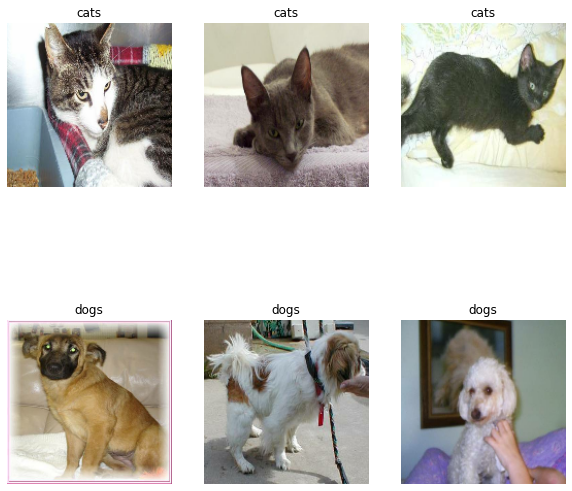

In [5]:
def two_row_visualization(train_dataset):
  # size of plot
  plt.figure(figsize=(10, 10))
  # for each image and label in one batch of 32 images
  for images, label in train_dataset.take(1):
    i = 0
    j = 0
    cats = 0
    dogs = 0
    # loop to get 3 cat photos
    while cats < 3:
      # plot image if it is of a cat starting in 1st row
      if label[i].numpy() == 0:
        ax = plt.subplot(2, 3, cats + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # add cats title and turn off axis
        plt.title("cats")
        plt.axis("off")
        cats = cats + 1
      # move to next image
      i = i + 1
    # loop to get 3 dog photos
    while dogs < 3:
      # plot image if it is of a dog starting in 2nd row
      if label[j].numpy() == 1:
        ax = plt.subplot(2, 3, dogs + 4)
        plt.imshow(images[j].numpy().astype("uint8"))
        # add dogs title and turn off axis
        plt.title("dogs")
        plt.axis("off")
        dogs = dogs + 1
      # move to next image
      j = j + 1
    
two_row_visualization(train_dataset)

## Check Label Frequencies

In [6]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [8]:
dogs = 0
for i in range(2000):
  dogs += labels_iterator.next()

dogs

1000

We see that there are 1000 images of dogs, meaning there are also 1000 images of cats. Since the *baseline* machine learning model is the model that always guesses the most frequent label, our baseline model would be 50% accurate since our image labels have equivalent frequencies.

## First Model

In [10]:
# Set up Model with three Conv2D layers, two MaxPooling2D layers, one Flatten layer, one Dropout layer, one Dense layer   
model1 = tf.keras.Sequential([                      
     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(32, (3, 3), activation='relu'),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(64, (3, 3), activation='relu'),
     layers.Flatten(),
     layers.Dropout(0.2),
     layers.Dense(2) # number of classes in the dataset                         
])

In [11]:
# Compile the model
model1.compile(optimizer='adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

In [12]:
# Train the model
history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 16s 85ms/step - loss: 13.0518 - accuracy: 0.5200 - val_loss: 0.6956 - val_accuracy: 0.5421
Epoch 2/20
63/63 [==============================] - 5s 76ms/step - loss: 0.6265 - accuracy: 0.6430 - val_loss: 0.7129 - val_accuracy: 0.5705
Epoch 3/20
63/63 [==============================] - 5s 77ms/step - loss: 0.5209 - accuracy: 0.7320 - val_loss: 0.7141 - val_accuracy: 0.6052
Epoch 4/20
63/63 [==============================] - 5s 77ms/step - loss: 0.4101 - accuracy: 0.8215 - val_loss: 0.7950 - val_accuracy: 0.5965
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 0.3015 - accuracy: 0.8700 - val_loss: 0.9154 - val_accuracy: 0.6275
Epoch 6/20
63/63 [==============================] - 5s 80ms/step - loss: 0.2215 - accuracy: 0.9185 - val_loss: 1.1231 - val_accuracy: 0.6300
Epoch 7/20
63/63 [==============================] - 5s 78ms/step - loss: 0.1572 - accuracy: 0.9470 - val_loss: 1.4207 - val_accuracy: 0.5879
Epoch 8/20


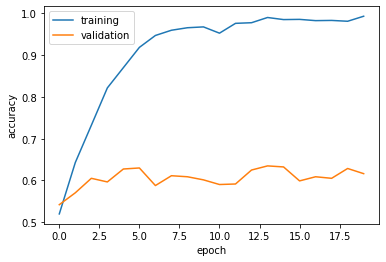

In [13]:
# Plotting accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

1. *The validation accuracy of* `model1` *stabilized* ***between 58% and 62%*** *during training.* 
2. Since the baseline model provided 50% accuracy, `model1` performed ***between 8% and 12%*** better than the baseline. 
3. Finally, the training accuracy is clearly much higher than the validation accuracy as epochs increase. Thus, overfitting has occurred in `model1`.

## Model with Data Augmentation

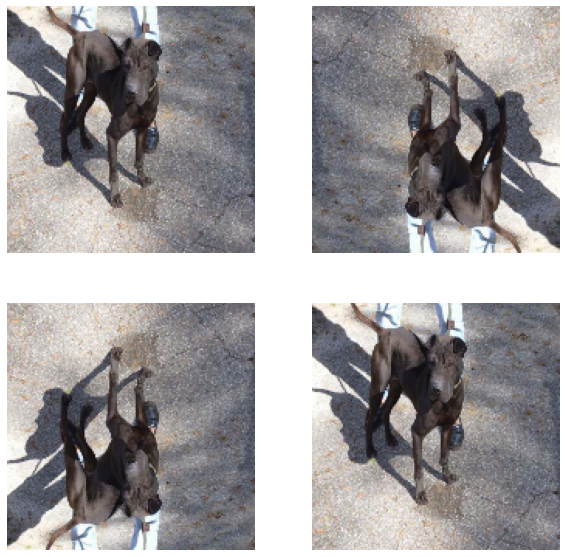

In [59]:
# Demonstration of tf.keras.layers.RandomFlip()
flip_image = tf.keras.layers.RandomFlip()

for image, _ in train_dataset.take(1):
  plt.figure(figsize = (10, 10))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    # apply random flip
    flipped = flip_image(tf.expand_dims(image[0], 0), training = True)
    plt.imshow(flipped[0] / 255)
    plt.axis('off')


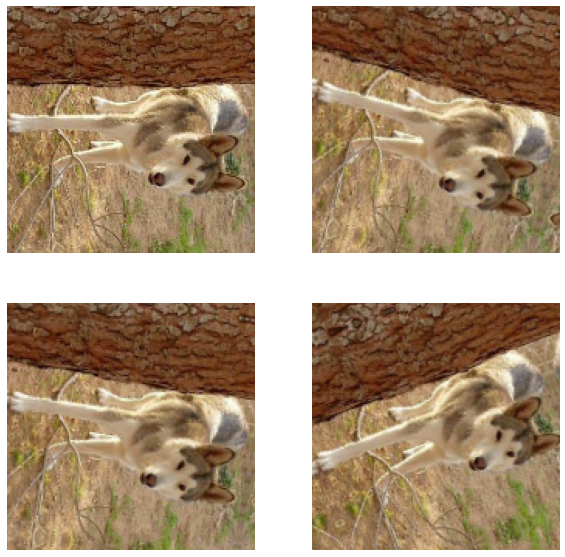

In [58]:
# Demonstration of tf.keras.layers.RandomRotation()
rotate_image = tf.keras.layers.RandomRotation(0.3)

for image, _ in train_dataset.take(1):
  plt.figure(figsize = (10, 10))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    # apply random flip
    rotated = rotate_image(tf.expand_dims(image[0], 0), training = True)
    plt.imshow(rotated[0] / 255)
    plt.axis('off')


In [60]:
# Set up the model with augmentation layers
model2 = tf.keras.Sequential([
      layers.RandomFlip(),                          
      layers.RandomRotation(0.2),
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(2)
])

In [44]:
# Compile the model
model2.compile(optimizer='adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

In [54]:
# Train the model
history = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 6s 89ms/step - loss: 0.6260 - accuracy: 0.6430 - val_loss: 0.6999 - val_accuracy: 0.6089
Epoch 2/20
63/63 [==============================] - 6s 85ms/step - loss: 0.6737 - accuracy: 0.5675 - val_loss: 0.6865 - val_accuracy: 0.5990
Epoch 3/20
63/63 [==============================] - 6s 90ms/step - loss: 0.6569 - accuracy: 0.6110 - val_loss: 0.6980 - val_accuracy: 0.5631
Epoch 4/20
63/63 [==============================] - 6s 88ms/step - loss: 0.6533 - accuracy: 0.6060 - val_loss: 0.7320 - val_accuracy: 0.5718
Epoch 5/20
63/63 [==============================] - 6s 88ms/step - loss: 0.6572 - accuracy: 0.6160 - val_loss: 0.6839 - val_accuracy: 0.6077
Epoch 6/20
63/63 [==============================] - 6s 91ms/step - loss: 0.6461 - accuracy: 0.6155 - val_loss: 0.6820 - val_accuracy: 0.5891
Epoch 7/20
63/63 [==============================] - 6s 90ms/step - loss: 0.6338 - accuracy: 0.6125 - val_loss: 0.6963 - val_accuracy: 0.5705
Epoch 8/20
63

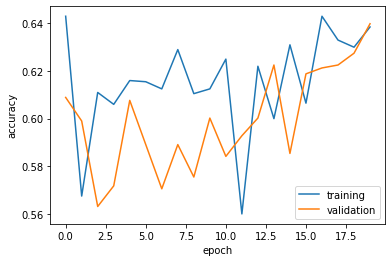

In [55]:
# Plotting accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

1. *The validation accuracy of* `model2` *stabilized* ***between 58% and 62%*** *during training.* 
2. `model2` performed relatively similar to `model1`. 
3. The training accuracy and the validation accuracy overlap and are relatively similar throughout the epochs. Thus, there is likely no overfitting in `model2`.

## Data Preprocessing

The following code will create a preprocessing layer called `preprocessor` to add into the model:

In [8]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [61]:
# Set up model with preprocessor added in
model3 = tf.keras.Sequential([
      preprocessor,                        
      layers.RandomFlip(),                          
      layers.RandomRotation(0.2),
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(2)
])

In [50]:
# Compile the model
model3.compile(optimizer='adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

In [52]:
# Train the model
history = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 9s 92ms/step - loss: 0.7190 - accuracy: 0.5215 - val_loss: 0.6750 - val_accuracy: 0.5842
Epoch 2/20
63/63 [==============================] - 6s 86ms/step - loss: 0.6820 - accuracy: 0.5795 - val_loss: 0.6538 - val_accuracy: 0.6225
Epoch 3/20
63/63 [==============================] - 6s 87ms/step - loss: 0.6433 - accuracy: 0.6170 - val_loss: 0.6911 - val_accuracy: 0.5941
Epoch 4/20
63/63 [==============================] - 6s 84ms/step - loss: 0.6390 - accuracy: 0.6185 - val_loss: 0.6387 - val_accuracy: 0.6163
Epoch 5/20
63/63 [==============================] - 6s 85ms/step - loss: 0.6224 - accuracy: 0.6465 - val_loss: 0.6087 - val_accuracy: 0.6473
Epoch 6/20
63/63 [==============================] - 6s 87ms/step - loss: 0.5989 - accuracy: 0.6665 - val_loss: 0.6081 - val_accuracy: 0.6535
Epoch 7/20
63/63 [==============================] - 6s 89ms/step - loss: 0.5845 - accuracy: 0.6815 - val_loss: 0.5875 - val_accuracy: 0.6782
Epoch 8/20
63

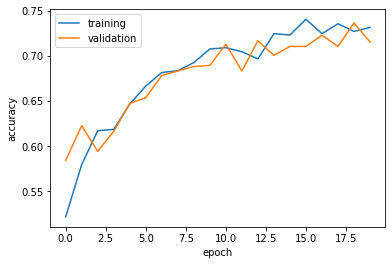

In [53]:
# Plotting accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

1. *The validation accuracy of* `model3` *stabilized* ***between 68% and 73%*** *during training.* 
2. `model3` performed better than both `model1` and `model2` by approximately ***10% - 11%***. 
3. The training accuracy and the validation accuracy overlap and are relatively similar throughout the epochs. Thus, there is likely no overfitting in `model3`.

## Transfer Learning

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
# Set up model
model4 = tf.keras.Sequential([
      preprocessor,
      layers.RandomFlip(),
      layers.RandomRotation(0.2),
      base_model_layer,
      layers.GlobalMaxPooling2D(),
      layers.Dropout(0.2),
      layers.Dense(2)                        
])

In [10]:
# Compile the model
model4.compile(optimizer='adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

In [13]:
# Train the model
history = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 8s 68ms/step - loss: 1.1655 - accuracy: 0.7360 - val_loss: 0.2175 - val_accuracy: 0.9394
Epoch 2/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6134 - accuracy: 0.8535 - val_loss: 0.1389 - val_accuracy: 0.9505
Epoch 3/20
63/63 [==============================] - 4s 59ms/step - loss: 0.4524 - accuracy: 0.8710 - val_loss: 0.0873 - val_accuracy: 0.9728
Epoch 4/20
63/63 [==============================] - 4s 59ms/step - loss: 0.4407 - accuracy: 0.8860 - val_loss: 0.0780 - val_accuracy: 0.9777
Epoch 5/20
63/63 [==============================] - 4s 58ms/step - loss: 0.4594 - accuracy: 0.8770 - val_loss: 0.0840 - val_accuracy: 0.9752
Epoch 6/20
63/63 [==============================] - 4s 60ms/step - loss: 0.4354 - accuracy: 0.8785 - val_loss: 0.1306 - val_accuracy: 0.9567
Epoch 7/20
63/63 [==============================] - 4s 59ms/step - loss: 0.4128 - accuracy: 0.8875 - val_loss: 0.0839 - val_accuracy: 0.9715
Epoch 8/20
63

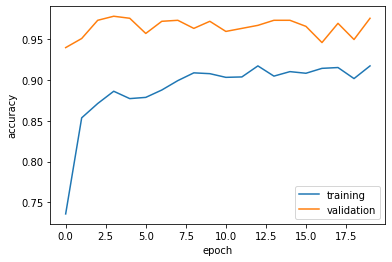

In [14]:
# Plotting accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

1. *The validation accuracy of* `model4` *stabilized* ***between 95% and 98%*** *during training.* 
2. `model4` performed much better than all of the past models by approximately ***20% - 30%***. 
3. The training accuracy is less than the validation accuracy throughout the epochs. Thus, there is likely no overfitting in `model4`.

## Evaluating Best Model on Testing Set

In [15]:
model4.evaluate(test_dataset)

6/6 [==============================] - 1s 41ms/step - loss: 0.0451 - accuracy: 0.9792


[0.045113492757081985, 0.9791666865348816]

As seen from earlier parts, my best performing model is `model4`. Thus, we evaluate this model on the unseen testing dataset. Clearly, this model performs very well, as our testing accuracy is ~98%. Therefore, we now have a very impressive model that can help us accurately identify images of cats and dogs.